## Executive Summary

This analysis evaluates customer churn risk using supervised classification models. Two models were developed and assessed: a baseline Logistic Regression model and a tuned Random Forest classifier. Model performance was evaluated using accuracy, precision, recall, and decision-threshold analysis to ensure alignment with business objectives.

---

## Key Results

### Baseline Logistic Regression
- **Test Accuracy:** ~81%
- **Optimized Decision Threshold:** ~34%
- **Precision at Optimized Threshold:** ~51%
- **Recall at Optimized Threshold:** ~42%

**Interpretation:**  
The Logistic Regression model was evaluated at an optimized decision threshold of approximately 34%, rather than the default 0.50 threshold. Lowering the threshold increases recall by classifying more customers as potential churners, but reduces precision due to a higher number of false positives. At this operating point, the model captures a larger share of churners than it would at the default threshold, though overall discriminative power remains limited.

---

### Tuned Random Forest
- **Train Accuracy:** ~85.7%
- **Test Accuracy:** ~87.6%
- **Optimized Decision Threshold:** ~28.9%
- **Precision at Optimized Threshold:** ~62.8%
- **Recall at Optimized Threshold:** ~62.8%

**Interpretation:**  
The tuned Random Forest model achieves higher overall accuracy than Logistic Regression. At its optimized threshold, precision and recall are equal, indicating a balanced operating point where the proportion of correctly identified churners matches the proportion of predicted churners that actually churn. The small gap between training and test accuracy suggests mild overfitting, which is acceptable given the improved generalization and balanced predictive performance.

---

## Explanation of Thresholds and Metrics

- **Decision Threshold:**  
  The probability cutoff used to convert predicted churn probabilities into class labels. Lower thresholds increase recall by reducing false negatives, while higher thresholds increase precision by reducing false positives.

- **Precision:**  
  The proportion of customers predicted to churn who actually churn. Higher precision reflects more reliable churn predictions.

- **Recall:**  
  The proportion of actual churners correctly identified by the model. Higher recall reflects stronger churn detection capability.

- **Balanced Precision and Recall:**  
  Precision and recall can be numerically equal at a specific threshold. This represents a deliberate tradeoff point—often near the threshold that maximizes the F1 score—and does not indicate a modeling error.

---

## Business Conclusion

The tuned Random Forest model provides a stronger and more flexible predictive framework than the Logistic Regression baseline. Its higher accuracy and balanced precision–recall performance at the optimized threshold make it better suited for churn prediction. Decision-threshold tuning enables alignment with business objectives, allowing prioritization of churn capture (higher recall) or cost control (higher precision) without retraining the model.


## 1. Profiling and Exploring the Data

#### 1.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

#### 1.2 Importing Dataset, Validating Dtypes, Checking for Null Values

In [2]:
dataset = pd.read_csv(r"C:\Users\gress\OneDrive\AG_Portfolio\Bank_Customer_Churn_Classification\Bank_Churn.csv")

In [3]:
dataset.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
dataset.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


##### Comments: No null values observed. Noted that dataset has already been cleaned.

#### 1.3 Reviewing Descriptive Statistics

In [6]:
dataset.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


##### Comments
* CreditScore: Mean score is 652, with a range from 350 to 850, which is within expected and valid bounds.
* Age: Average customer age is approximately 39 years, ranging from 18 to 92, indicating a realistic adult customer population.
* Tenure: Mean tenure is 5 years, with values between 0 and 10 years. This suggests either the dataset captures only the first decade of customer relationships or the bank has operated for roughly ten years.
* Balance: Average account balance is approximately 76,000 USD. Given the average customer age, this appears reasonable. Balances range from 0 to 250,000 USD.
* NumOfProducts: Customers hold between 1 and 4 products, with most holding 1–2, which aligns with typical retail banking behavior.
* HasCrCard: Approximately 70 percent of customers have an associated credit card.
* IsActiveMember: About 52 percent of customers are classified as active members, indicating moderate engagement.
* EstimatedSalary: Average estimated salary is around 100,000 USD, with values ranging from 11.58 to nearly 200,000 USD. The lower bound may indicate a data encoding issue or a non-annualized salary figure.
* Exited: Roughly 20 percent of customers have churned, indicating a moderately imbalanced target variable.

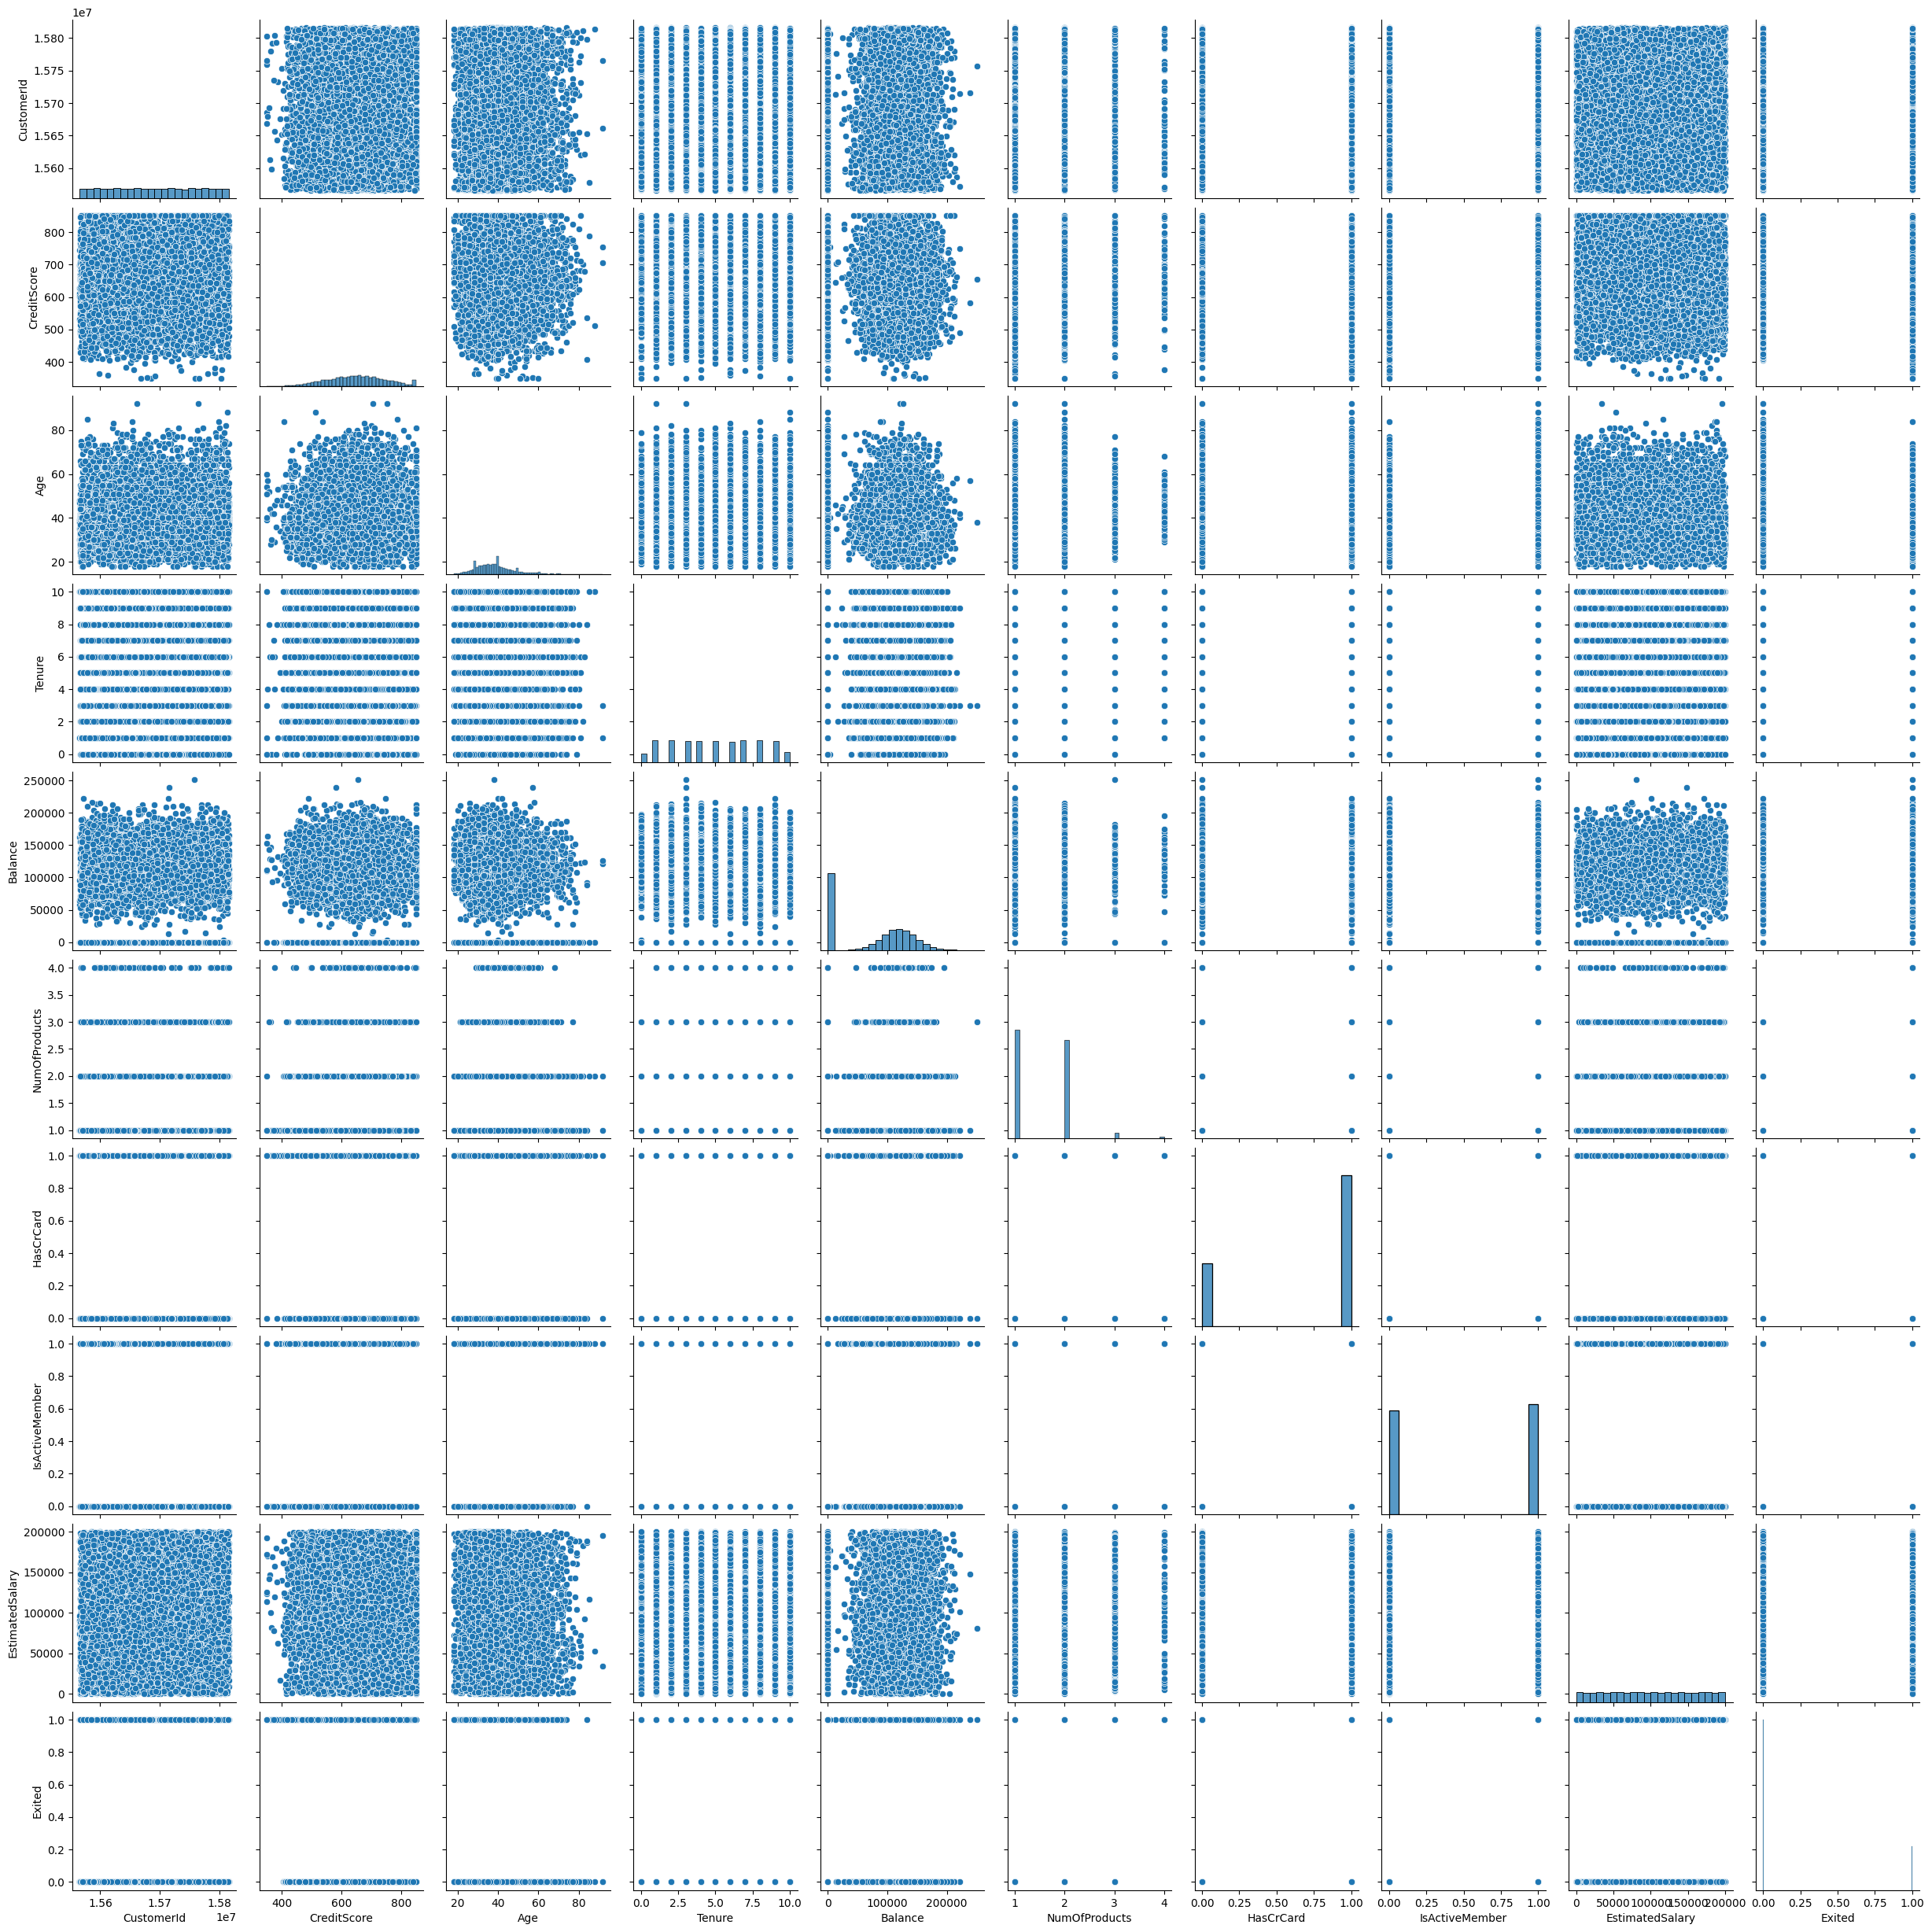

In [7]:
sns.pairplot(dataset);

##### Pairplot Observations
* CreditScore: Appears approximately normally distributed across the valid credit score range, with no obvious skew or truncation effects.
* Gender: Customer base is roughly balanced by gender, with approximately 45 percent female and 55 percent male.
* Age: Approximately normally distributed with a mean around 39 years and a standard deviation of about 10 years.
* Tenure: Displays an approximately uniform distribution across the tenure range.
* Balance: Contains a large outlier near 250,000 USD. Excluding this observation, balances appear approximately normally distributed.
* NumOfProducts: Majority of customers hold 1–2 products. Holdings of 3–4 products are relatively rare.
* HasCrCard: Roughly 70 percent of customers have a credit card and 30 percent do not. Given the dataset size (approximately 10,000 records), this imbalance is not concerning.
* IsActiveMember: Nearly evenly split, with about 51.5 percent active members and 48.5 percent inactive members.
* EstimatedSalary: Uniformly distributed across the salary range rather than normally distributed, indicating even representation across salary bands.
* Geography (France, Germany, Spain): Approximately 50 percent of customers are from France, while the remaining customers are evenly split between Germany and Spain (roughly 25 percent each).
* Multicollinearity: No meaningful multicollinearity observed among features.


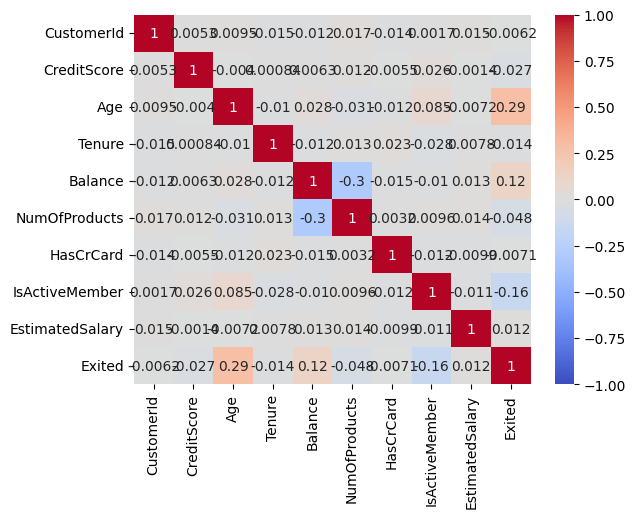

In [8]:
sns.heatmap(dataset.corr(numeric_only=True), vmin=-1, vmax=1, cmap='coolwarm', annot=True);

##### Correlation
* Age exhibits a weak positive correlation with churn (r = 0.29). This indicates that, on average, the likelihood of churn increases slightly as customer age increases.
* Balance exhibits a very weak positive correlation with churn (r = 0.12). Customers with higher account balances are marginally more likely to churn, though this relationship is weak and likely influenced by other factors such as age, tenure, and product mix.
* These correlations represent linear associations only and do not imply causation. Individually weak correlations may still contribute predictive value within multivariate and non-linear models.

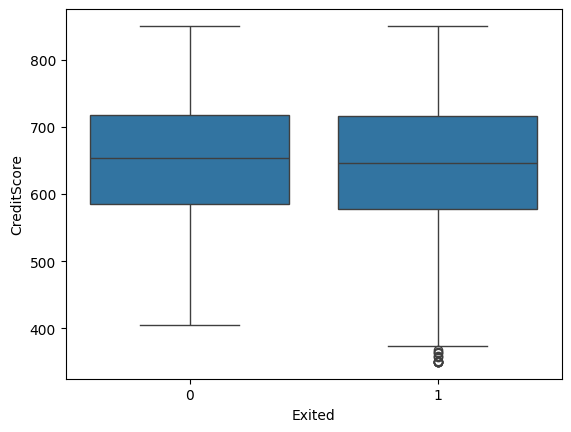

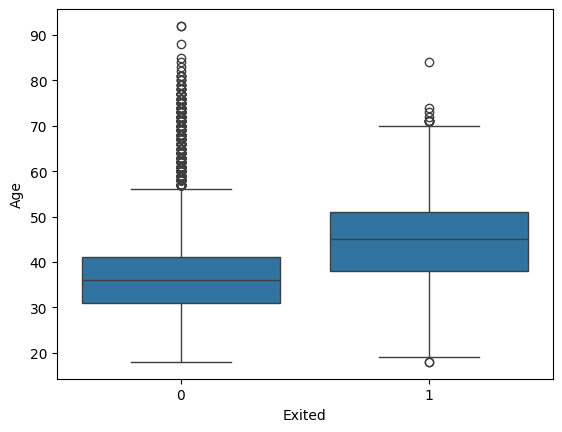

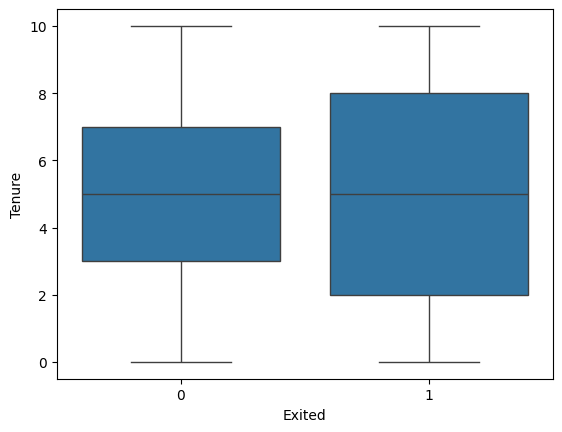

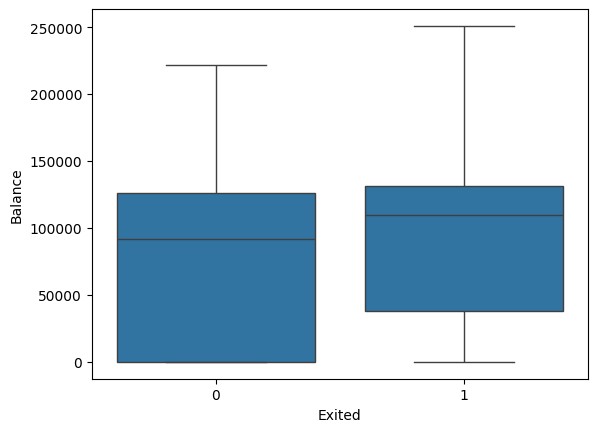

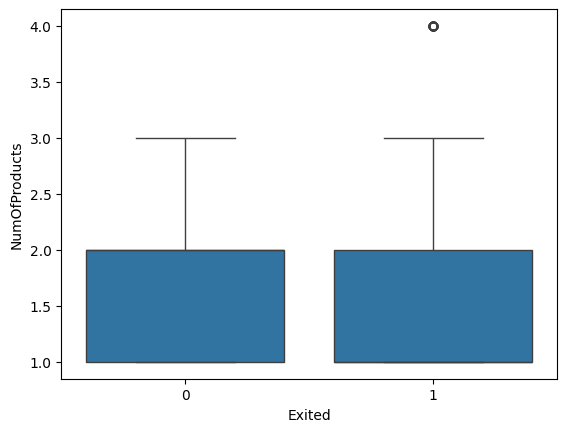

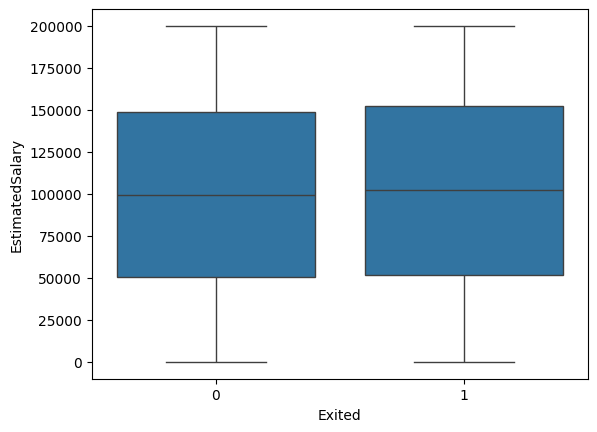

In [9]:
for col in dataset.select_dtypes("number").drop(columns=['CustomerId','HasCrCard', 'IsActiveMember', 'Exited']):
    sns.boxplot(data=dataset, x='Exited', y=col)
    plt.show();

##### Boxplot Analysis
* CreditScore: Churners and non-churners show very similar distributions. Both groups have a median credit score around 650 with comparable interquartile ranges. While churners exhibit some lower-score outliers, there is no meaningful separation between the groups.
* Age: Churners tend to be noticeably older than non-churners, with median ages of approximately 45 years versus 35 years, respectively. The age distribution for non-churners appears right-skewed with a substantial number of higher-age outliers, warranting further investigation.
* Tenure: Median tenure is nearly identical for churners and non-churners at roughly 5 years. However, churners exhibit a wider interquartile range (approximately 6 years versus 4 years), indicating greater variability in tenure.
* Balance: Churners generally maintain slightly higher account balances, on the order of 5,000–10,000 USD more than non-churners. These customers may represent higher-value accounts from a retention perspective.
* NumOfProducts: Product ownership patterns are broadly similar between churners and non-churners. Churners include an outlier with the maximum number of products, which may merit closer examination as a potential high-value churn case.
* EstimatedSalary: Salary distributions are nearly identical between churners and non-churners, suggesting limited discriminative power for this feature in isolation.

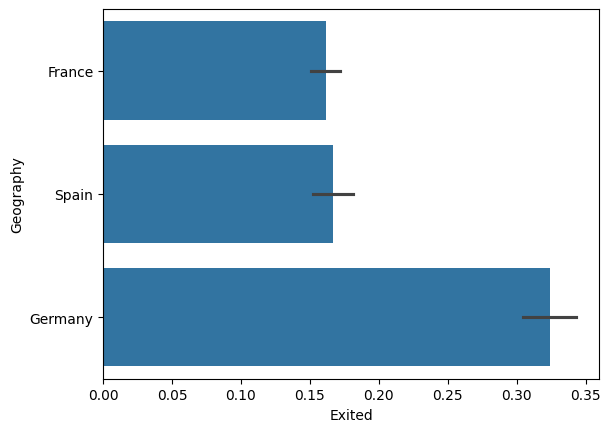

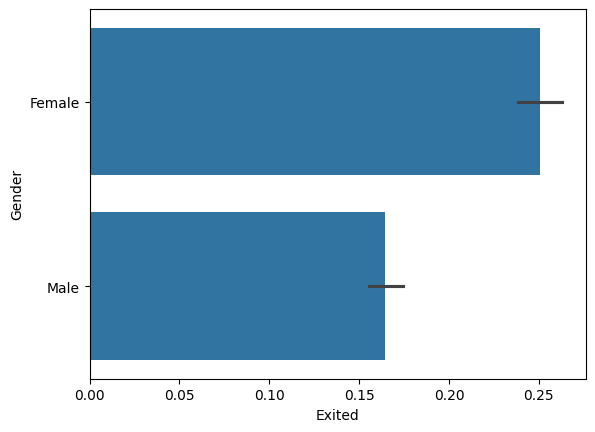

In [10]:
for col in dataset.select_dtypes("object").drop(columns=['Surname']):
    sns.barplot(data=dataset, x='Exited', y=col)
    plt.show();

##### Barplot Analysis
* Geography: Germany exhibits the highest churn rate at approximately 32 percent, while France and Spain show substantially lower and similar churn rates of around 17 percent.
* Gender: Female customers display a higher churn rate (approximately 25 percent) compared to male customers (approximately 15 percent).
* Both geography and gender demonstrate meaningful differences in churn rates and appear to be potentially informative features for modeling churn.

## 2. Prepare the Data for Modeling

#### 2.1 Dropping Columns Not Suitable for Modeling

In [11]:
dataset_subset = dataset.drop(columns=['CustomerId', 'Surname'])
dataset_subset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### 2.2 Engineering New Features

In [12]:
dataset_subset.query("NumOfProducts== 0") 

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [13]:
dataset_subset.query("EstimatedSalary == 0")

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


##### Comments
* No cases were denominator is 0 so don't have to worry about inf values.

In [14]:
dataset_subset['balance_to_income'] = dataset_subset.Balance / dataset_subset.EstimatedSalary

In [15]:
dataset_subset['income_v_products'] = dataset_subset.EstimatedSalary / dataset_subset.NumOfProducts

##### Comments
* balance_to_income: Represents the proportion of a customer’s account balance relative to their estimated income. Higher values may indicate customers with substantial assets who are less dependent on the bank’s services and therefore potentially more likely to churn.
* income_v_products: Represents the amount of estimated income per product held. Higher values may indicate under-penetrated, high-income customers, suggesting missed cross-sell opportunities and a potentially elevated risk of churn.

#### 2.3 Analyzing Engineered Features

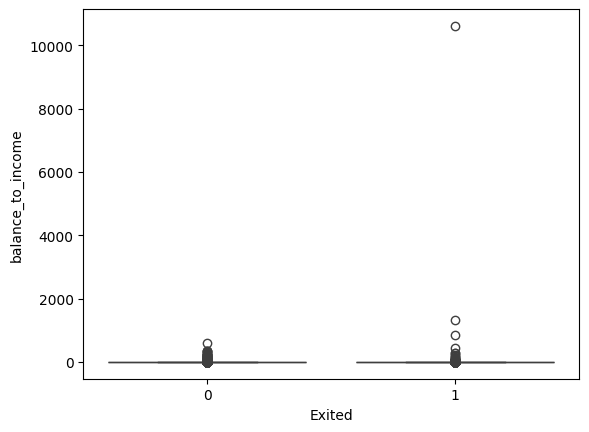

In [16]:
sns.boxplot(dataset_subset, x='Exited', y='balance_to_income');

##### Comments
* An extreme outlier is observed in the balance_to_income feature, with a value approaching 10,000. This outlier heavily skews the distribution, so extreme values will be filtered to obtain a clearer and more interpretable boxplot. The observation suggests a customer with a very high balance relative to reported income, which may reflect an atypical financial situation such as asset transfers, inheritance, or other non-salary income.


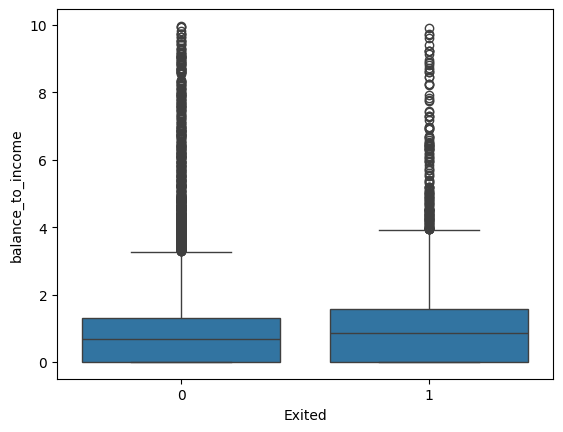

In [17]:
sns.boxplot(dataset_subset.query('balance_to_income <= 10'), x='Exited', y='balance_to_income');

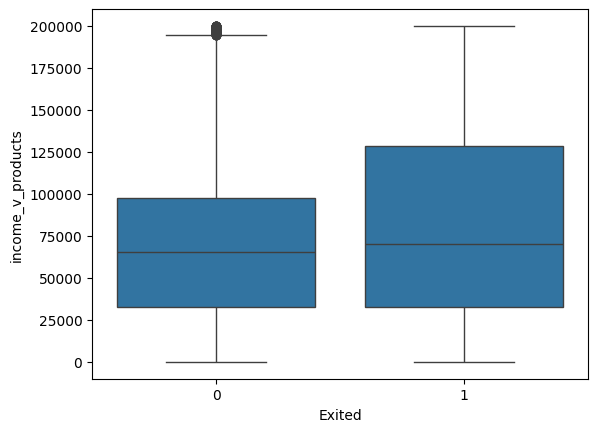

In [18]:
sns.boxplot(dataset_subset, x='Exited', y='income_v_products');

##### Comments
* balance_to_income: The median ratio is close to 1 for both churners and non-churners, suggesting limited separation in isolation. However, this feature may still contribute predictive value through interaction effects in multivariate models.
* income_v_products: The median value is approximately 65,000 for both churners and non-churners. Notably, churners exhibit greater variability, with a wider interquartile range (approximately 95,000 versus 65,000), indicating increased heterogeneity among customers who exit.

#### 2.4 Preparing Dataset for Modeling

In [19]:
dataset_subset = pd.get_dummies(dataset_subset, drop_first=True, dtype="int")

In [20]:
dataset_subset.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_to_income,income_v_products,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.000000,101348.880,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.744677,112542.580,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.401375,37977.190,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.000000,46913.315,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1.587055,79084.100,0,1,0


In [21]:
X = dataset_subset.drop(columns='Exited')
y = dataset_subset['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 8276 to 7816
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        8000 non-null   int64  
 1   Age                8000 non-null   int64  
 2   Tenure             8000 non-null   int64  
 3   Balance            8000 non-null   float64
 4   NumOfProducts      8000 non-null   int64  
 5   HasCrCard          8000 non-null   int64  
 6   IsActiveMember     8000 non-null   int64  
 7   EstimatedSalary    8000 non-null   float64
 8   balance_to_income  8000 non-null   float64
 9   income_v_products  8000 non-null   float64
 10  Geography_Germany  8000 non-null   int64  
 11  Geography_Spain    8000 non-null   int64  
 12  Gender_Male        8000 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 875.0 KB


In [23]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 8374 to 8466
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        2000 non-null   int64  
 1   Age                2000 non-null   int64  
 2   Tenure             2000 non-null   int64  
 3   Balance            2000 non-null   float64
 4   NumOfProducts      2000 non-null   int64  
 5   HasCrCard          2000 non-null   int64  
 6   IsActiveMember     2000 non-null   int64  
 7   EstimatedSalary    2000 non-null   float64
 8   balance_to_income  2000 non-null   float64
 9   income_v_products  2000 non-null   float64
 10  Geography_Germany  2000 non-null   int64  
 11  Geography_Spain    2000 non-null   int64  
 12  Gender_Male        2000 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 218.8 KB


##### Comments:
* Split 80% into train and 20% into test.

## 3. Building and Evaluating a Logistic Regression Model

In [24]:
logreg = LogisticRegression(solver='newton-cholesky')
lr = logreg.fit(X_train, y_train)
print(f"Train Accuracy: {lr.score(X_train, y_train)}")

Train Accuracy: 0.817


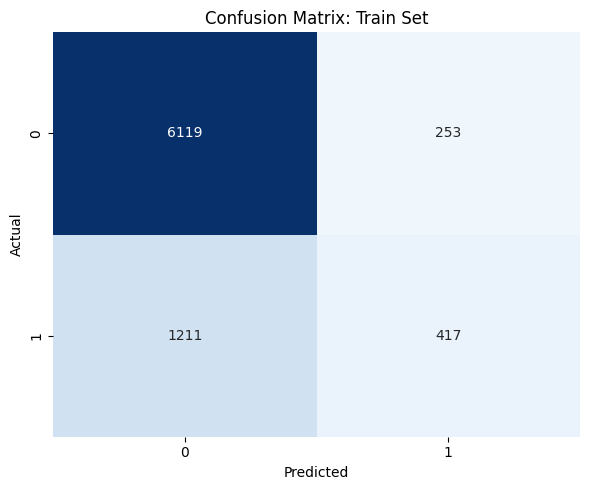

In [25]:
cm = confusion_matrix(y_train, lr.predict(X_train))

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    vmin=0,
    vmax=cm.max(),
    cbar=False
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Train Set')
plt.tight_layout()
plt.show()

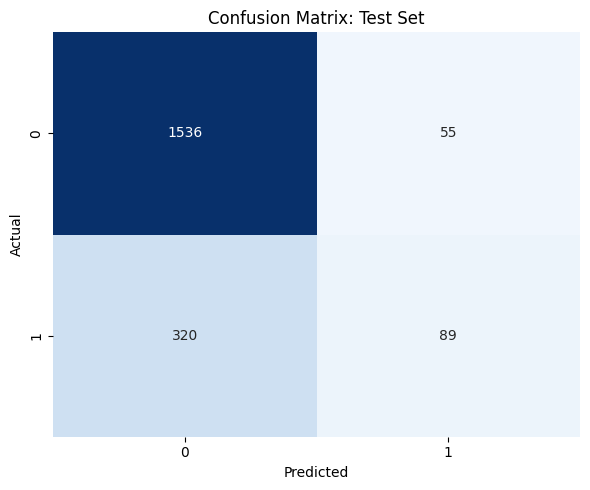

In [26]:
cm = confusion_matrix(y_test, lr.predict(X_test))

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    vmin=0,
    vmax=cm.max(),
    cbar=False
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Test Set')
plt.tight_layout()
plt.show()

In [27]:
print(f"Train Accuracy: {round(lr.score(X_train, y_train),3)}")
print(f"Test Accuracy: {round(lr.score(X_test, y_test),3)}")
print("--------------------------")
print(f"Train Precision: {round(precision_score(y_train, lr.predict(X_train)),3)}")
print(f"Test Precision: {round(precision_score(y_test, lr.predict(X_test)),3)}")
print("--------------------------")
print(f"Train Recall: {round(recall_score(y_train, lr.predict(X_train)),3)}")
print(f"Test Recall: {round(recall_score(y_test, lr.predict(X_test)),3)}")
print("--------------------------")
print(f"Train F1: {round(f1_score(y_train, lr.predict(X_train)),3)}")
print(f"Test F1: {round(f1_score(y_test, lr.predict(X_test)),3)}")

Train Accuracy: 0.817
Test Accuracy: 0.812
--------------------------
Train Precision: 0.622
Test Precision: 0.618
--------------------------
Train Recall: 0.256
Test Recall: 0.218
--------------------------
Train F1: 0.363
Test F1: 0.322


##### Comments:
* Accuracy: Accuracy is high and nearly identical on train and test sets, indicating good generalization and no meaningful overfitting.
* Precision: When the model predicts a customer will churn, it is correct about 62 percent of the time. This is a reasonably strong precision score and suggests the model is conservative in flagging churners.
* The model identifies only about 22–26 percent of actual churners.
This indicates the model misses a large portion of customers who eventually churn, which is common when using the default probability threshold (0.5) in imbalanced datasets.
* F1 Score: The F1 score reflects the tradeoff between precision and recall.
The relatively low values confirm that recall is the limiting factor in overall performance.

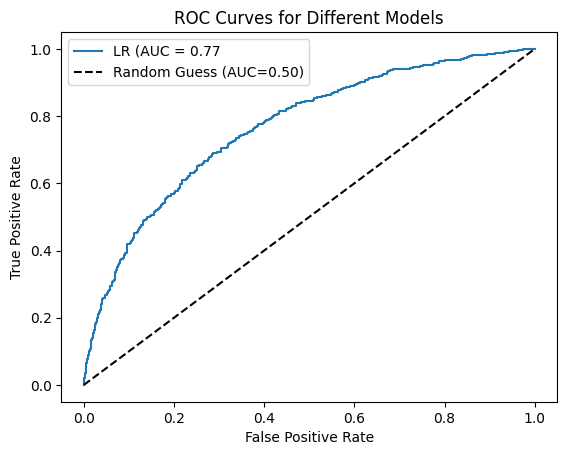

In [28]:
y_probs = lr.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_probs)
auc_score = auc(fpr1, tpr1)

# Plot the ROC curve
plt.plot(fpr1, tpr1, label=f'LR (AUC = {auc_score:.2f}');

# Draw random guess
plt.plot([0,1], [0, 1], 'k--', label='Random Guess (AUC=0.50)');

# Modify format
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

##### Comments:
* Initial base model is better than a random guess across all tresholds, however will try to fine tune.

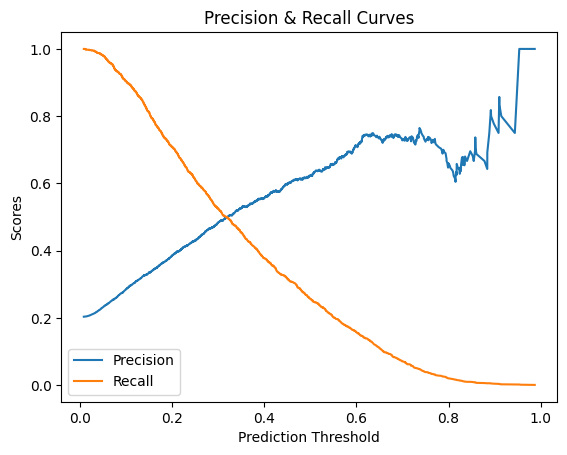

In [29]:
p_curve, r_curve, t_curve = precision_recall_curve(
    y_train,
    lr.predict_proba(X_train)[:, 1]
)

plt.plot(t_curve, p_curve[:-1], label='Precision')
plt.plot(t_curve, r_curve[:-1], label='Recall')

plt.xlabel('Prediction Threshold')
plt.ylabel('Scores')
plt.legend()
plt.title('Precision & Recall Curves')
plt.show()

##### Comments:
* Goal is to fine tune model so precision is above 0.5.

In [30]:
np.where(p_curve > 0.5)

(array([6377, 6383, 6384, ..., 7998, 7999, 8000], shape=(1619,)),)

In [31]:
t_curve[6377]

np.float64(0.3197171449360367)

##### Comments
* A prediction threshold of approximately 0.32 increases precision above 50 percent while maintaining a reasonable balance with recall. The threshold is adjusted upward to 0.34 to provide additional margin and ensure precision remains above 0.50.

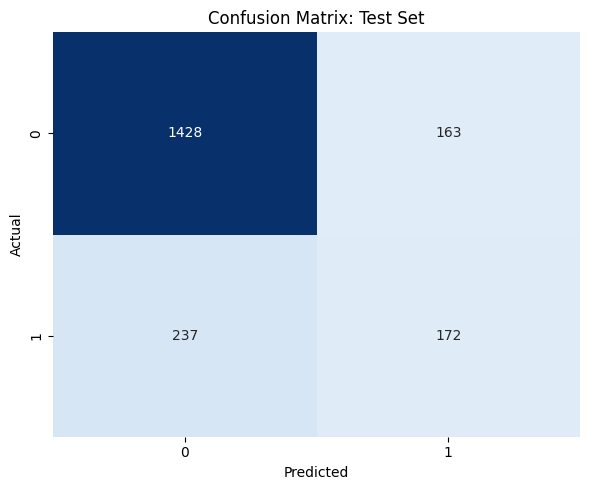

In [32]:
cm = confusion_matrix(y_test, lr.predict_proba(X_test)[:, 1] > .34)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    vmin=0,
    vmax=cm.max(),
    cbar=False
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Test Set')
plt.tight_layout()
plt.show()

In [33]:
recall_score(y_test, lr.predict_proba(X_test)[:, 1] > .34)

0.42053789731051344

In [34]:
precision_score(y_test, lr.predict_proba(X_test)[:, 1] > .34)

0.5134328358208955

##### Comments
* The tuned model achieves a recall of 0.42 and a precision of 0.51. This means the model correctly identifies approximately 42 percent of customers who actually churn, while about 51 percent of customers predicted to churn do in fact churn. Compared to the baseline model, this reflects an improved ability to capture churners, albeit with an expected tradeoff in prediction certainty.

## 4. Fitting and Tuning a Random Forest Model

#### 4.1 Fitting the Random Forest Model with Default Parameters

In [35]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

In [36]:
print(f"Train Accuracy: {round(rf.score(X_train, y_train),3)}")
print(f"Test Accuracy: {round(rf.score(X_test, y_test),3)}")

Train Accuracy: 1.0
Test Accuracy: 0.856


##### Comments:
* The model perfectly classifies every training observation. This almost never reflects true signal and strongly suggests the model has memorized the training data. Performance drops substantially on unseen data, showing the model does not generalize well and is overfit.

## 4.2 Hyperparameter Tuning Round 1

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

X_tune1 = X_train.sample(frac=0.2, random_state=2023)
y_tune1 = y_train.loc[X_tune1.index]

rf_round1 = RandomForestClassifier(
    n_estimators=200,
    random_state=2023,
    n_jobs=1
)

param_grid_round1 = {
    'min_samples_leaf': [10, 20],
    'max_samples': [0.5, 0.8],
    'max_depth': [None, 8],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

grid_round1 = GridSearchCV(
    rf_round1,
    param_grid_round1,
    cv=3,
    scoring="accuracy",
    n_jobs=1,
    verbose=1
)

grid_round1.fit(X_tune1, y_tune1)

best_params_round1 = grid_round1.best_params_

best_params_round1

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 0.8,
 'min_samples_leaf': 10}

## 4.3 Hyperparameter Tuning Round 2

In [39]:
X_tune2 = X_train.sample(frac=0.2, random_state=2023)
y_tune2 = y_train.loc[X_tune2.index]

rf_round2 = RandomForestClassifier(
    n_estimators=200,
    criterion="gini",
    random_state=2023,
    n_jobs=1,
    **best_params_round1
)

param_dist_round2 = {
    'min_samples_leaf': [8, 10, 12],
    'max_depth': [None, 10],
    'max_samples': [0.75, 0.8, 0.85]
}

search_round2 = RandomizedSearchCV(
    rf_round2,
    param_distributions=param_dist_round2,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=1,
    verbose=1,
    random_state=2023
)

search_round2.fit(X_tune2, y_tune2)

best_params_round2 = search_round2.best_params_

best_params_round2

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'min_samples_leaf': 12, 'max_samples': 0.8, 'max_depth': 10}

## 4.4 Hyperparameter Tuning Round 3 - Final

In [40]:
final_model = RandomForestClassifier(
    n_estimators=500,
    criterion="gini",
    max_features="sqrt",
    bootstrap=True,
    random_state=2023,
    n_jobs=-1,
    **best_params_round2
)

final_model.fit(X_train, y_train)

print(f"Train Accuracy: {final_model.score(X_train, y_train)}")
print(f"Test Accuracy: {final_model.score(X_test, y_test)}")

Train Accuracy: 0.876125
Test Accuracy: 0.8565


In [44]:
from sklearn.metrics import precision_score, recall_score, classification_report

y_pred = final_model.predict(X_test)

precision = precision_score(y_test, y_pred, average="binary")   # use "macro", "micro", or "weighted" for multiclass
recall = recall_score(y_test, y_pred, average="binary")

precision, recall

(0.824468085106383, 0.37897310513447435)

In [46]:
import numpy as np
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

y_proba = final_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))
optimal_threshold = thresholds[idx]

y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)

optimal_threshold, optimal_precision, optimal_recall

(np.float64(0.2890563959703857), 0.628361858190709, 0.628361858190709)

##### Comments:
* Test Accuracy: 87.6 percent.
* Train Accuracy: 85.7 percent.
* Optimal Threshold: 28.9 percent.
* Precision: 62.8% percent.
* Recall: 62.8% percent.
* Model slightly overfit by a few percentage points but not concenred. Higher accuracy than logistic regression model.

## 4.5 Analyzing Random Forrest Accuracy and AUC

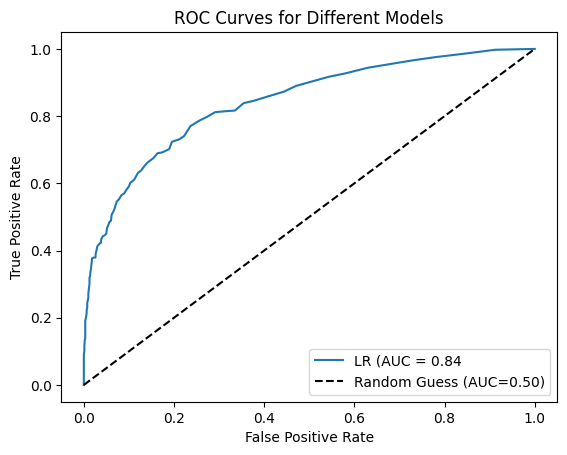

In [41]:
y_probs = rf.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_probs)
auc_score = auc(fpr1, tpr1)

# Plot the ROC curve
plt.plot(fpr1, tpr1, label=f'LR (AUC = {auc_score:.2f}');

# Draw random guess
plt.plot([0,1], [0, 1], 'k--', label='Random Guess (AUC=0.50)');

# Modify format
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

## 4.6 Reviewing Features Importance

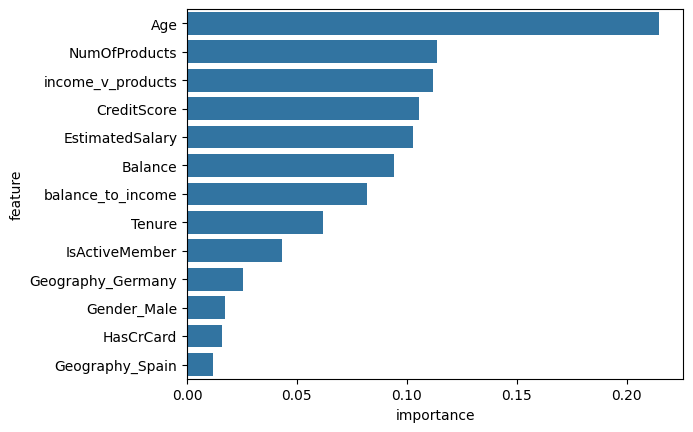

In [43]:
importance = (
    pd.DataFrame(
        {
            "feature": X_train.columns,
            "importance": rf.feature_importances_
        }
    )
    .sort_values("importance", ascending=False)
    .iloc[:20]
)

sns.barplot(
    data=importance,
    x="importance",
    y="feature"
);